<i>This is the open source code of paper: Introducing causal inference in the energy-efficient building design process.<br>
@Date : 2022-06-24 16:21:35<br>
@Link : https://doi.org/10.48550/arXiv.2203.10115<br>
@Ver : v02<br>
@Author: Xia CHEN (xia.chen@iek.uni-hannover.de), Jimmy Abualdenien, Manav Mahan Singh, André Borrmann, Philipp Geyer<br>
For using the code or data, please cite:<br>

- <i>Chen, X., Abualdenien, J., Singh, M.M., Borrmann, A. and Geyer, P., 2022. Introducing causal inference in the energy-efficient building design process. arXiv preprint arXiv:2203.10115.</i>

In [3]:
import warnings
import pandas as pd
import numpy as np
import os, sys, gc, time, warnings, pickle, psutil, random
from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from math import ceil

import dowhy
import statsmodels

import pygraphviz as pgv
import cdt
import networkx as nx
from cdt.causality.graph import GES


cdt.SETTINGS.rpath = 'E:/R/R-4.0.5/bin/Rscript' # path to your r executable
# cdt.SETTINGS.verbose = True

warnings.filterwarnings("ignore")

Detecting 1 CUDA device(s).


In [14]:
def read_data(TARGET):
    data = pd.read_csv(TARGET + '.csv')
    data.columns = data.columns.str.replace(' ','_')
    data.columns = data.columns.str.replace('-','_')
    data.columns = data.columns.str.replace(':','_')
    data.columns = data.columns.str.replace('(','')
    data.columns = data.columns.str.replace(')','')
#     print(data.columns)
    data = data[[ 'Height', 'Volume', 'External_Wall_Area', 
                 'Number_of_Floors', 'Ground_Floor_Area', 'Window_Area', 'u_Value_Wall', 'u_Value_Ground_Floor', 
                 'u_Value_Roof', 'u_Value_Internal_Floor', 'u_Value_Internal_Wall', 'u_Value_Windows', 
                 'g_Value_Windows',  'Permeability',  
                 'Building_Equipment_Heat_Gain', 'Building_Occupancy', 
                 'WWR_North','WWR_East','WWR_West','WWR_South','Floor_Area',
                 'Heating_Load', 'Cooling_Load']]

    data['WWR'] = (data['WWR_North'] + data['WWR_East'] + data['WWR_West'] + data['WWR_South'])/4

    return data

# Result & Evaluation
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def MAPE(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

def MAE(F, A):
    return 1/len(A) * np.sum(np.abs(F - A))


def MSE(F, A):
    return 1/len(A) * np.sum(pow(np.abs(F - A),2))

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    

# Data description


In the original dataset, we defined additional parameters to randomly generate the geometry of the buildings. <br>
To simplify the case in causal discovery, we re-generate the data by restricting building geometry to box-shape for causal skeleton learning.<br><br>
Detailed data descriptions you can find at:
- <i>Singh, Manav Mahan; Singaravel, Sundaravelpandian; Klein, Ralf; Geyer, Philipp  (2020). Quick energy prediction and comparison of options at the early design stage. Advanced Engineering Informatics, 46(), 101185–.doi:10.1016/j.aei.2020.101185</i>  
        

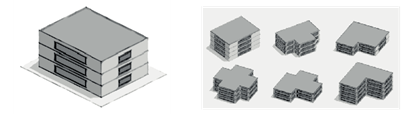

In [15]:
TARGET_Relationship = 'Building_BoxShape'
TARGET_Effect = 'Building_RandomShape'

# Causal relationship learning

In [16]:
data = read_data(TARGET_Relationship)
data = data.drop(columns=['Cooling_Load'])
# data = data.drop(columns=['EUI', 'Cooling_Load', 'Heating_Load'])
data.describe()

,Height,Volume,External_Wall_Area,Number_of_Floors,Ground_Floor_Area,Window_Area,u_Value_Wall,u_Value_Ground_Floor,u_Value_Roof,u_Value_Internal_Floor,...,Permeability,Building_Equipment_Heat_Gain,Building_Occupancy,WWR_North,WWR_East,WWR_West,WWR_South,Floor_Area,Heating_Load,WWR
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.499758,5404.013452,720.577977,3.501000,440.71375,308.698955,0.199990,0.199941,0.199998,0.499867,...,7.497352,12.000156,19.995938,0.299891,0.299891,0.299684,0.299834,1544.090480,5006.623275,0.299825
std,0.288842,2540.498577,253.456252,0.957557,156.70537,123.040136,0.028884,0.028881,0.028879,0.057769,...,0.866397,1.155304,2.310483,0.115523,0.115523,0.115521,0.115524,711.318823,1609.105688,0.057823
min,3.000000,864.000000,216.091194,2.000000,144.00000,28.800000,0.150000,0.150000,0.150000,0.400000,...,6.000000,10.000000,16.000000,0.100000,0.100000,0.100000,0.100000,288.000000,1510.421197,0.100000
25%,3.249756,3500.840797,531.768051,3.000000,321.68250,215.756498,0.174976,0.174976,0.174976,0.449951,...,6.749268,10.999023,17.998047,0.199902,0.199902,0.199902,0.199902,1026.292500,3785.149565,0.259375
50%,3.499512,4950.094789,689.713577,3.500000,416.54000,293.480245,0.199951,0.199951,0.199951,0.499902,...,7.498535,11.998047,19.996094,0.299805,0.299805,0.299805,0.299805,1415.835000,4917.630942,0.301563
75%,3.749268,6916.275598,872.208368,4.000000,543.91500,377.478230,0.224927,0.224927,0.224927,0.549854,...,8.247803,12.997070,21.994141,0.399707,0.399707,0.399707,0.399707,1951.327500,5955.989879,0.337500
max,3.999023,16777.334782,1800.077258,5.000000,875.86000,842.549357,0.249902,0.249902,0.249902,0.599805,...,8.997070,13.996094,23.992188,0.499609,0.499609,0.499609,0.499609,4379.300000,11187.831395,0.462500


array([[<AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'External_Wall_Area'}>,
        <AxesSubplot:title={'center':'Number_of_Floors'}>,
        <AxesSubplot:title={'center':'Ground_Floor_Area'}>],
       [<AxesSubplot:title={'center':'Window_Area'}>,
        <AxesSubplot:title={'center':'u_Value_Wall'}>,
        <AxesSubplot:title={'center':'u_Value_Ground_Floor'}>,
        <AxesSubplot:title={'center':'u_Value_Roof'}>,
        <AxesSubplot:title={'center':'u_Value_Internal_Floor'}>],
       [<AxesSubplot:title={'center':'u_Value_Internal_Wall'}>,
        <AxesSubplot:title={'center':'u_Value_Windows'}>,
        <AxesSubplot:title={'center':'g_Value_Windows'}>,
        <AxesSubplot:title={'center':'Permeability'}>,
        <AxesSubplot:title={'center':'Building_Equipment_Heat_Gain'}>],
       [<AxesSubplot:title={'center':'Building_Occupancy'}>,
        <AxesSubplot:title={'center':'WWR_North'}>,
        

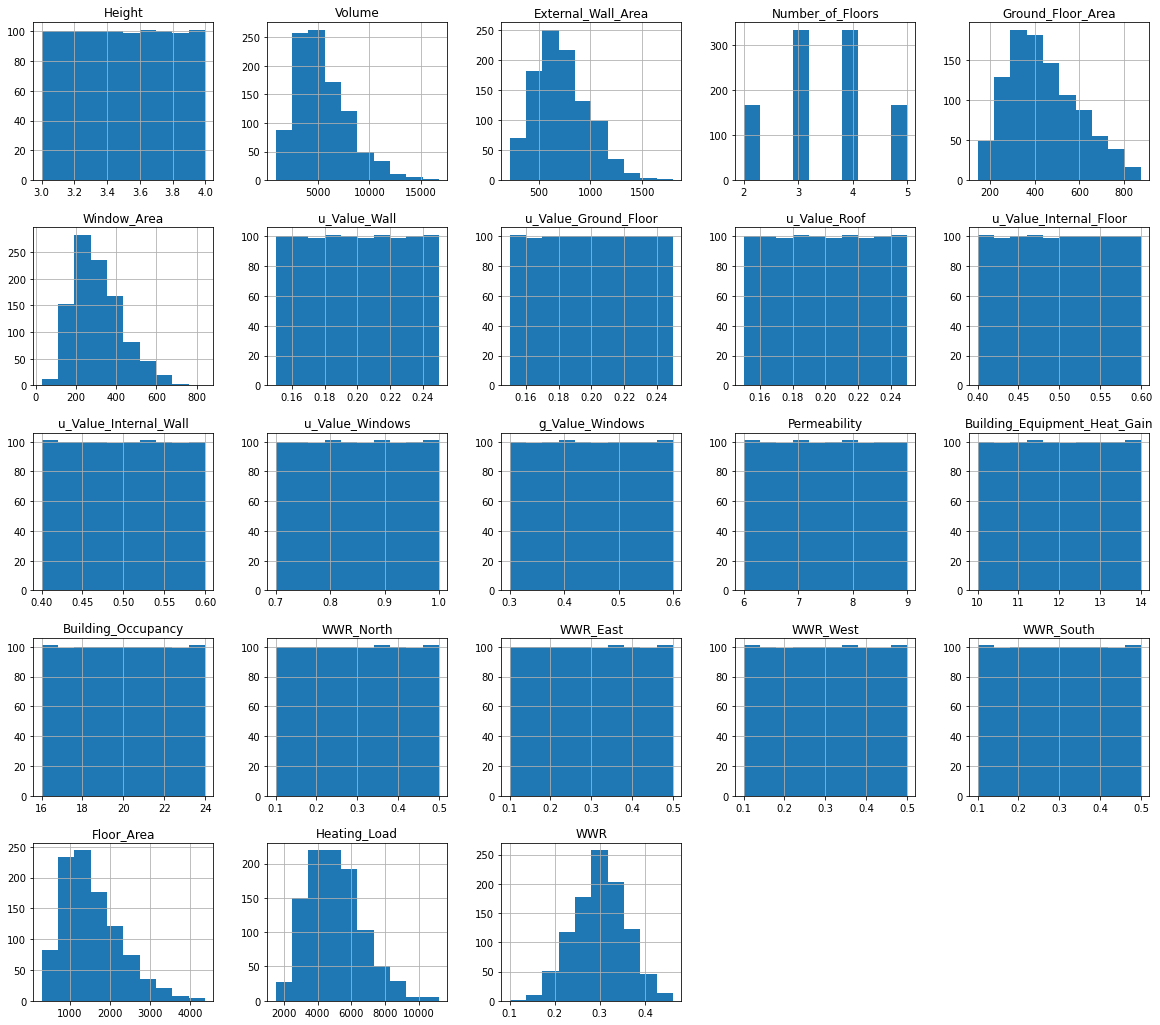

In [17]:
plt.rcParams["figure.figsize"] = (20,18)
data.hist()

## Step 1: Discover the causal skeleton

We tried several algorithms with domain-knowledge evaluation. Eventually, we decide to use the Greedy-Equivalent-Search algorithm to discover the causal skeleton.

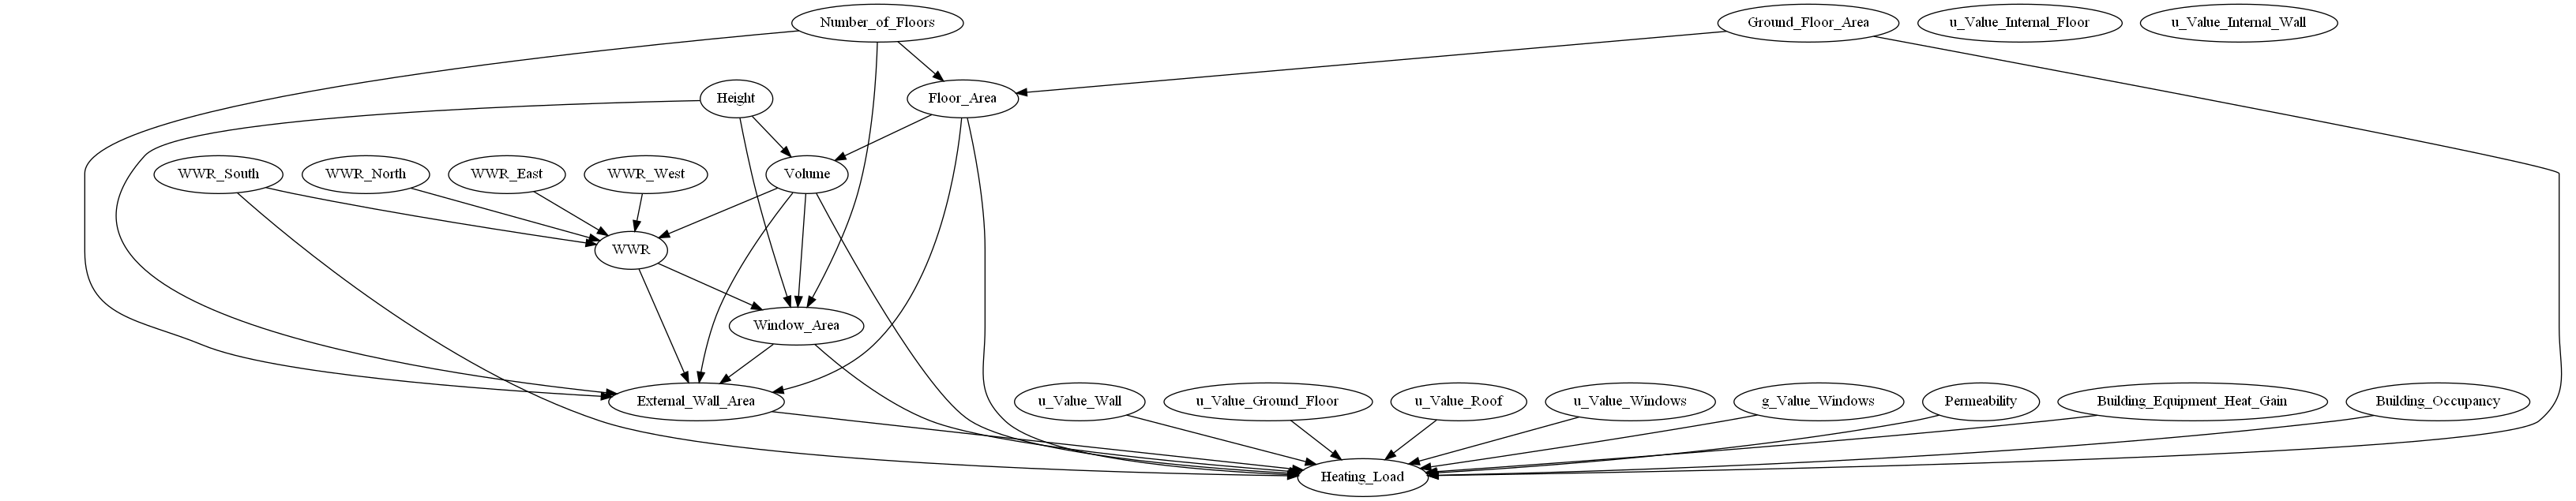

In [18]:
# Use Greedy-Equivalent-Search algorithm to discover the causal skeleton
# First data
df_skeleton = data.copy()
obj = GES()
output = obj.predict(df_skeleton) 

# Convert to Graph
A = nx.nx_agraph.to_agraph(output) 
A.layout(prog='dot')
A.draw("file.png")
Image('file.png')

Using causal discovery in the parametric building design process can help us to be informed:
1. whether correlations between parameters and the output (e.g. internal u-values don't affect the heating load)
2. kinships of parameters (ancestors/descendants)
3. design process reference (top-down)

## Step 2: Prune causal relations via domain knowledge

The skeleton generated by the causal discovery algorithm provides a good reference for us to further prune with domain knowledge, <br><i>or</i><br> we can generate skeletons with our prior knowledge/assumptions.

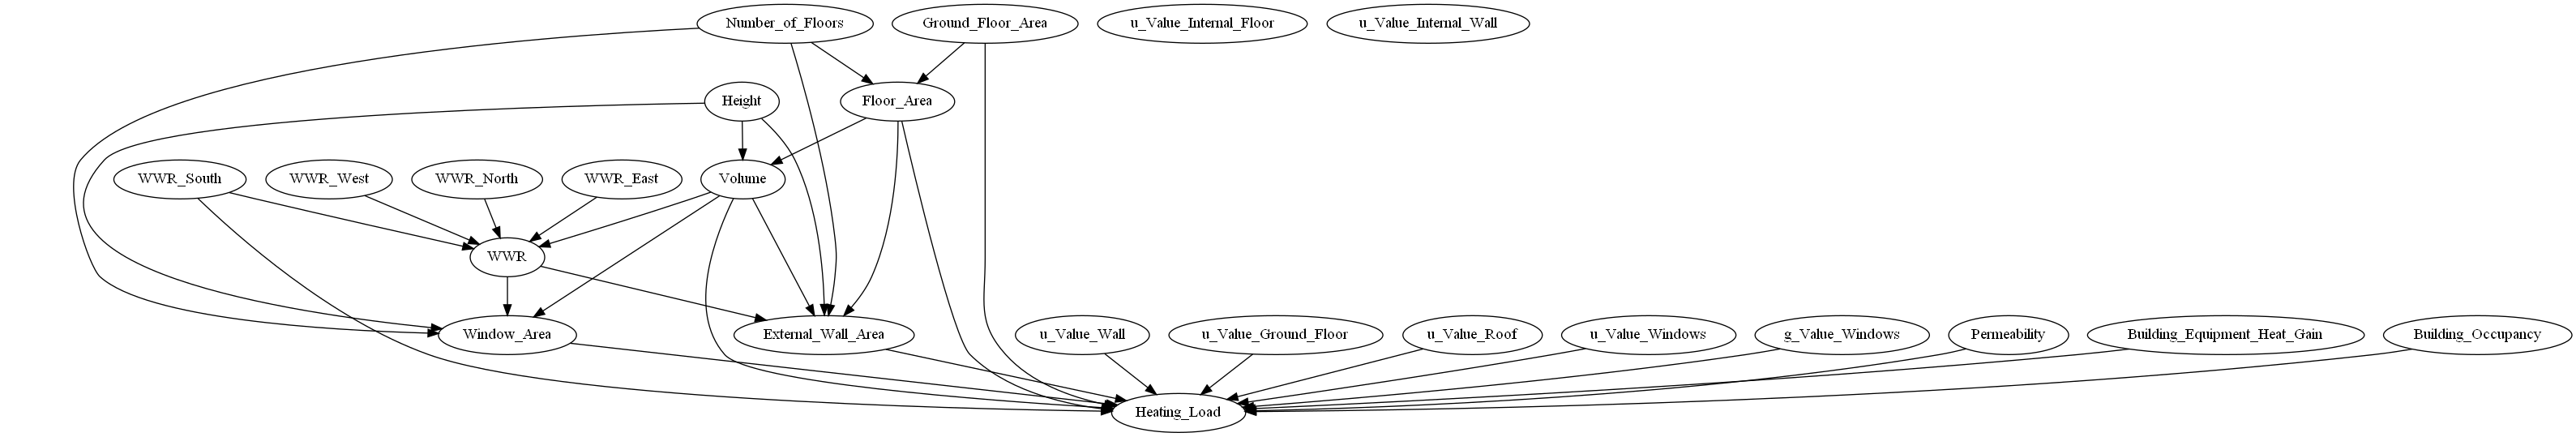

In [19]:
# Use domain knowledge to prune relationships
# A.remove_edge('External_Wall_Area',v='Window_Area')
A.remove_edge('Window_Area',v='External_Wall_Area')

A.layout(prog="dot")
A.draw("file.png")
Image('file.png')

Skeleton can be manually coded by using `pygraphviz`.

In [20]:
# Coding causal skeleton
causal_graph = """digraph {
Height;
Volume;
External_Wall_Area;
Window_Area;
Heating_Load;
Number_of_Floors;
Ground_Floor_Area;
u_Value_Wall;
u_Value_Ground_Floor;
u_Value_Roof;
u_Value_Internal_Floor;
u_Value_Internal_Wall;
u_Value_Windows;
g_Value_Windows;
Permeability;
Building_Equipment_Heat_Gain;
Building_Occupancy;
WWR_North;
WWR_East;
WWR_West;
WWR_South;

Height -> Volume;
Height -> External_Wall_Area;
Height -> Window_Area;
Height -> Heating_Load;
Height -> WWR;
Volume -> Heating_Load;
External_Wall_Area -> Volume;
External_Wall_Area -> Heating_Load;
Window_Area -> Volume;
Window_Area -> Heating_Load;
WWR -> External_Wall_Area;
WWR -> Window_Area;
Number_of_Floors -> Volume;
Number_of_Floors -> External_Wall_Area;
Number_of_Floors -> Window_Area;
Number_of_Floors -> Heating_Load;
Ground_Floor_Area -> Volume;
Ground_Floor_Area -> External_Wall_Area;
Ground_Floor_Area -> Window_Area;
Ground_Floor_Area -> Heating_Load;
u_Value_Wall -> Heating_Load;
u_Value_Ground_Floor -> Heating_Load;
u_Value_Roof -> Heating_Load;
u_Value_Internal_Floor;
u_Value_Internal_Wall;
u_Value_Windows -> Heating_Load;
g_Value_Windows -> Heating_Load;
Permeability -> Heating_Load;
Building_Equipment_Heat_Gain -> Heating_Load;
Building_Occupancy -> Heating_Load;
WWR_North -> WWR;
WWR_East -> WWR;
WWR_West -> WWR;
WWR_South -> Heating_Load;
WWR_South -> WWR;
}"""

To analyze and visualize assumptions in the causal skeleton, such as:<br>
 - "*What if I change the window area, how does it change the heating load?*"
 - "*What if I change the building floor height, how does it change the heating load?*"<br>
 
we use tool **[Dagitty](http://dagitty.net/dags.html)**:
 
 - *Textor, Johannes, Juliane Hardt, and Sven Knüppel. "DAGitty: a graphical tool for analyzing causal diagrams." Epidemiology 22.5 (2011): 745.*

# Causal effect estimation

In [21]:
# loading dataset
data = read_data(TARGET_Effect)
data = data.drop(columns=['Cooling_Load'])

## Step 3: Identify desired causal effect

In this step, by using properties of the causal skeleton, we identify the causal effect to be estimated in our dataset.

In [22]:
model= dowhy.CausalModel(
        data = data,
        graph=causal_graph.replace("\n", " "),
        treatment="Height",
        outcome="Heating_Load")
print('Model done!')

# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Model done!
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                               
─────────(Expectation(Heating_Load))
d[Height]                           
Estimand assumption 1, Unconfoundedness: If U→{Height} and U→Heating_Load then P(Heating_Load|Height,,U) = P(Heating_Load|Height,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



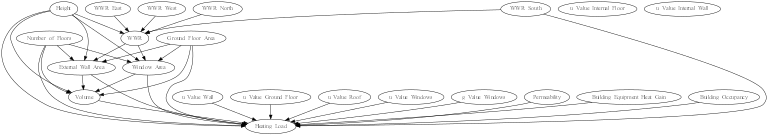

In [23]:
# Check model skeleton
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Step 4: Potential outcome estimation

We use *backdoor criterion*:<br>
 - <i>Backdoor Criterion — Given an ordered pair of variables (X, Y) in a directed acyclic graph G, a set of variables Z satisfies the backdoor criterion relative to (X, Y) if no node in Z is a descendant of X, and Z blocks every path between X and Y that contains an arrow into X.</i>

with simple [linear regression](https://py-why.github.io/dowhy/dowhy.causal_estimators.html#module-dowhy.causal_estimators.linear_regression_estimator) from `dowhy` package to answer question:<br>
 - <i>"What if I had changed floor height from 3 meters to 3.2 meters, how does it make difference on heating load?"</i>

In [24]:
# Average treatment effect
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",
                                 control_value=3,
                                 treatment_value=3.2,
                                )
print(estimate.interpret())

linear_regression
{'control_value': 3, 'treatment_value': 3.2, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['Permeability', 'WWR_West', 'u_Value_Windows', 'Building_Equipment_Heat_Gain', 'WWR_North', 'u_Value_Roof', 'g_Value_Windows', 'Number_of_Floors', 'u_Value_Ground_Floor', 'WWR_East', 'Building_Occupancy', 'Ground_Floor_Area', 'u_Value_Wall', 'WWR_South']}
Increasing the treatment variable(s) [Height] from 3 to 3.2 causes an increase of 390.67565017096877 in the expected value of the outcome [Heating_Load], over the data distribution/population represented by the dataset.
None


The "*ground truth*" generated by the first-principle simulation (run 200 sampled rounds)

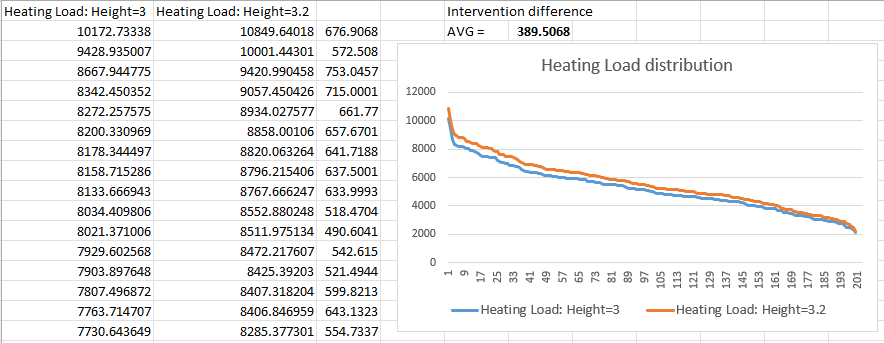

In [25]:
# Conditional average treatment effect
output_df = pd.DataFrame(estimate.estimate_conditional_effects(num_quantiles=10))
output_df

0
__categorical__Permeability __categorical__WWR_West __categorical__u_Value_Windows __categorical__Building_Equipment_Heat_Gain __categorical__WWR_North __categorical__u_Value_Roof __categorical__g_Value_Windows __categorical__Number_of_Floors __categorical__u_Value_Ground_Floor __categorical__WWR_East __categorical__Building_Occupancy __categorical__Ground_Floor_Area __categorical__u_Value_Wall __categorical__WWR_South            
(5.999, 6.299]              (0.099, 0.14]           (0.699, 0.73]                  (9.999, 10.402]                             (0.099, 0.14]            (0.149, 0.16]               (0.299, 0.33]                  (1.999, 3.0]                    (0.149, 0.16]                       (0.099, 0.14]           (15.999, 16.796]                  (249.97899999999998, 305.441]    (0.149, 0.16]               (0.099, 0.14]             165.564374
                                                    (0.73, 0.76]                   (13.2, 13.598]                              (0.42, 0.46]             (0.23, 0.24]                (0.33, 0.36]                   (3.5, 4.0]                      (0.2, 0.21]                         (0.099, 0.14]           (18.388, 19.192]                  (414.546, 469.95]                (0.17, 0.18]                (0.3, 0.34]               327.409187
                                                    (0.76, 0.79]                   (10.804, 11.202]                            (0.26, 0.3]              (0.17, 0.18]                (0.299, 0.33]                  (1.999, 3.0]                    (0.22, 0.23]                        (0.3, 0.34]             (20.792, 21.588]                  (579.718, 634.473]               (0.24, 0.25]                (0.26, 0.3]               341.032885
                                                                                   (12.4, 12.802]                              (0.14, 0.18]             (0.149, 0.16]               (0.299, 0.33]                  (1.999, 3.0]                    (0.149, 0.16]                       (0.18, 0.22]            (21.588, 22.384]                  (249.97899999999998, 305.441]    (0.21, 0.22]                (0.38, 0.42]              182.405661
                                                    (0.79, 0.82]                   (11.202, 11.6]                              (0.38, 0.42]             (0.24, 0.25]                (0.33, 0.36]                   (4.0, 5.0]                      (0.2, 0.21]                         (0.18, 0.22]            (23.188, 23.992]                  (469.95, 524.755]                (0.24, 0.25]                (0.14, 0.18]              456.875959
...                                                                                                                                                                                                                                                                                                                                                                                                                                            ...
(8.699, 8.997]              (0.46, 0.5]             (0.85, 0.88]                   (12.4, 12.802]                              (0.42, 0.46]             (0.17, 0.18]                (0.33, 0.36]                   (1.999, 3.0]                    (0.17, 0.18]                        (0.18, 0.22]            (17.592, 18.388]                  (360.084, 414.546]               (0.22, 0.23]                (0.26, 0.3]               382.502845
                                                    (0.88, 0.91]                   (9.999, 10.402]                             (0.22, 0.26]             (0.2, 0.21]                 (0.33, 0.36]                   (3.5, 4.0]                      (0.149, 0.16]                       (0.34, 0.379]           (21.588, 22.384]                  (524.755, 579.718]               (0.19, 0.2]                 (0.3, 0.34]               516.907332
                                                                                   

The "*ground truth*" generated by the first-principle simulation (run 200 sampled rounds), based on:
 - ***E[Heating Load│Height=3.2m,X]-E[Heating Load│Height=3m,X]***<Br>

,where X is *[Building Equipment Heat Gain, Building Occupancy, Ground Floor Area=300, Number of Floors=3, WWRs=0.3, u Value Roof=0.2, Ground Floor u Value=0.2, Permeability=7.5]*

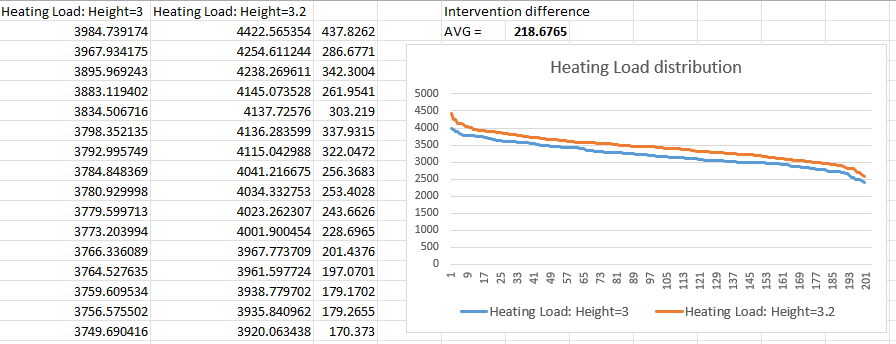

## Comparison: Using Machine Learning model to answer "What-if"

In this section, we use pure machine learning(ML) models as a comparison in order to show that:
 - "*Answering "what-if" questions without considering parametric independencies leads to biased outcome/spurious conclusion.*"<br>
 
, which should rise more attention when using ML models to do (building performance) simulations.

In [24]:
# Lightgbm(https://github.com/microsoft/LightGBM)

Target_features = ['Heating_Load']
features = [col for col in list(data) if col not in Target_features]
TARGET = Target_features[0]
########################### Model params #################################################################################
lgb_params = {
            'boosting_type': 'gbdt',
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.1,
            'feature_fraction': 0.5,
            'boost_from_average': False,
            'verbose': -1,
            'n_jobs': -1,
            }

########################### Vars #################################################################################
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


X = data[features]
y = data[Target_features[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, 
                   label=y_train)

estimator = lgb.cv(
                    lgb_params,
                    train_data,
                    num_boost_round=10000,
                    nfold=4,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    stratified=False,
                    seed=42
)

print('Best RMSE in cv is: {:.5f}，std: {:.5f}.'.format(
estimator['rmse-mean'][-1], estimator['rmse-stdv'][-1]))

print('Best iteration is {}.'.format(len(estimator['rmse-mean'])))

estimator = lgb.train(lgb_params,
                      train_data,
                      verbose_eval = 100,
                      num_boost_round = int(len(estimator['rmse-mean'])), ###########
                      )

[100]	cv_agg's rmse: 555.383 + 18.1022
[200]	cv_agg's rmse: 540.696 + 22.214
[300]	cv_agg's rmse: 539.882 + 21.7926
Best RMSE in cv is: 538.56875，std: 20.13733.
Best iteration is 232.


In [15]:
y_pred = estimator.predict(X_test)
print('Result RMSE is {}, SMAPE is {}, R^2 is {}'.format('%.4f' % RMSE(y_pred, y_test), 
                                                         '%.4f' % MAPE(y_pred, y_test), 
                                                         '%.4f' % metrics.r2_score( y_test, y_pred)))

# lgb.plot_importance(estimator, ignore_zero=False)

Result RMSE is 564.1945, SMAPE is 0.0694, R^2 is 0.9254


In typical regression task(data --> train/test split, cv), ML gives accurate prediction result(92.5%)

Suppose we have no information or prior knowledge regarding the dependencies of parameters.<br>
To simulate this scenario, we simply create data by setting the height 3m and 3.2m and keep the rest of the parameters unchanged.<br>

In [22]:
TARGET_NO_CASUSAL_3 = '.\ML\ATE\Building_3'
TARGET_NO_CASUSAL_3_2 = '.\ML\ATE\Building_3.2'
df_3 = read_data(TARGET_NO_CASUSAL_3)
df_3_2 = read_data(TARGET_NO_CASUSAL_3_2)

In [23]:
df_3_X = df_3[features]
df_3_2_X = df_3_2[features]

y_pred_3 = estimator.predict(df_3_X)
y_pred_3_2 = estimator.predict(df_3_2_X)
diff = y_pred_3_2.mean()-y_pred_3.mean()
print('ATE predicted by ML is:',str(diff))

ATE predicted by ML is: 65.77372641699822


In [21]:
TARGET_NO_CASUSAL_3 = '.\ML\CATE\Building_3'
TARGET_NO_CASUSAL_3_2 = '.\ML\CATE\Building_3.2'
df_3 = read_data(TARGET_NO_CASUSAL_3)
df_3_2 = read_data(TARGET_NO_CASUSAL_3_2)

df_3_X = df_3[features]
df_3_2_X = df_3_2[features]

y_pred_3 = estimator.predict(df_3_X)
y_pred_3_2 = estimator.predict(df_3_2_X)
diff = y_pred_3_2.mean()-y_pred_3.mean()
print('CATE predicted by ML is:',str(diff))

CATE predicted by ML is: 47.24318498473076


Both results own huge bias; ML without causal-informed explored unrealistic parameter space and concluded falsely.